In [1]:
import pymc as pm
import arviz as az
import preliz as pz

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
az.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

### Generate data

In [2]:
np.random.seed(101)
num_samples = 5000

default_rates_new = np.random.standard_t(df=3, size=num_samples) * 0.01 + 0.01  # smaller mean and scale
default_rates_repeated = np.random.standard_t(df=3, size=num_samples) * 0.02 + 0.03  # higher mean and scale

In [3]:
# sample_distribution = sns.displot(
#     data = default_rates_prior_new,
#     kde = True,
#     aspect = 1.5,
#     alpha = 0.5
# )

# sample_distribution.fig.suptitle('Distribution of Sampled Data For New Clients')

# plt.tight_layout();

### Specify model

In [4]:
with pm.Model() as default_rate_model:
    # Priors for the mean default rates for new and repeated clients
    mu_new = pm.HalfNormal('mu_new', sigma=0.01)  # Small sigma as default rates are expected to be low
    mu_repeated = pm.HalfNormal('mu_repeated', sigma=0.02)  # Slightly higher variability for repeated clients
    
    # Priors for the standard deviation of default rates
    sigma_new = pm.InverseGamma('sigma_new', alpha=2, beta=0.01)
    sigma_repeated = pm.InverseGamma('sigma_repeated', alpha=2, beta=0.02)

    # Prior for the degrees of freedom, lower range for capturing Black Swan events
    nu = pm.DiscreteUniform('nu', lower=2, upper=5)

    # StudentT likelihoods for the observed data
    likelihood_new = pm.StudentT('likelihood_new', nu=nu, mu=mu_new, sigma=sigma_new, observed=default_rates_new)
    likelihood_repeated = pm.StudentT('likelihood_repeated', nu=nu, mu=mu_repeated, sigma=sigma_repeated, observed=default_rates_repeated)

    # Posterior sampling
    trace = pm.sample(5000, tune=2500)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_new, mu_repeated, sigma_new, sigma_repeated]
>Metropolis: [nu]


Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 10 seconds.


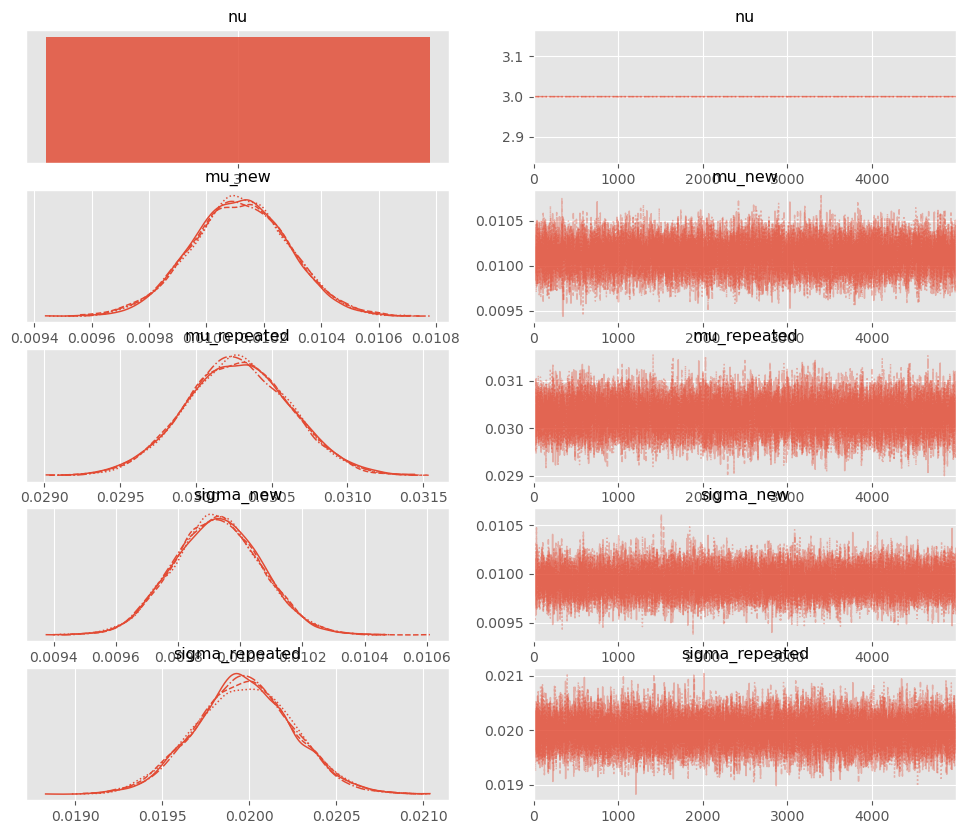

In [5]:
az.plot_trace(trace);

In [6]:
#az.plot_trace(trace, kind="rank_bars", combined=True, rank_kwargs={"colors": "k"});

In [7]:
# Summarize the trace for diagnostics
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
nu,3.00,0.0,3.000,3.000,0.0,0.0,20000.0,20000.0,NaN
mu_new,0.01,0.0,0.010,0.010,0.0,0.0,34116.0,16546.0,1.0
mu_repeated,0.03,0.0,0.030,0.031,0.0,0.0,35913.0,16870.0,1.0
sigma_new,0.01,0.0,0.010,0.010,0.0,0.0,36953.0,16337.0,1.0
sigma_repeated,0.02,0.0,0.019,0.020,0.0,0.0,32908.0,15446.0,1.0


In [13]:
with pm.Model() as default_rate_model:
    mu_new = pm.HalfNormal('mu_new', sigma=0.01)
    mu_repeated = pm.HalfNormal('mu_repeated', sigma=0.02)  
    
    sigma_new = pm.InverseGamma('sigma_new', alpha=2, beta=0.01)
    sigma_repeated = pm.InverseGamma('sigma_repeated', alpha=2, beta=0.02)

    # Prior for the degrees of freedom, wider range 
    nu = pm.Uniform('nu', lower=1, upper=3)

    likelihood_new = pm.StudentT('likelihood_new', nu=nu, mu=mu_new, sigma=sigma_new, observed=default_rates_new)
    likelihood_repeated = pm.StudentT('likelihood_repeated', nu=nu, mu=mu_repeated, sigma=sigma_repeated, observed=default_rates_repeated)

    trace = pm.sample(5000, tune=2500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_new, mu_repeated, sigma_new, sigma_repeated, nu]


Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 16 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


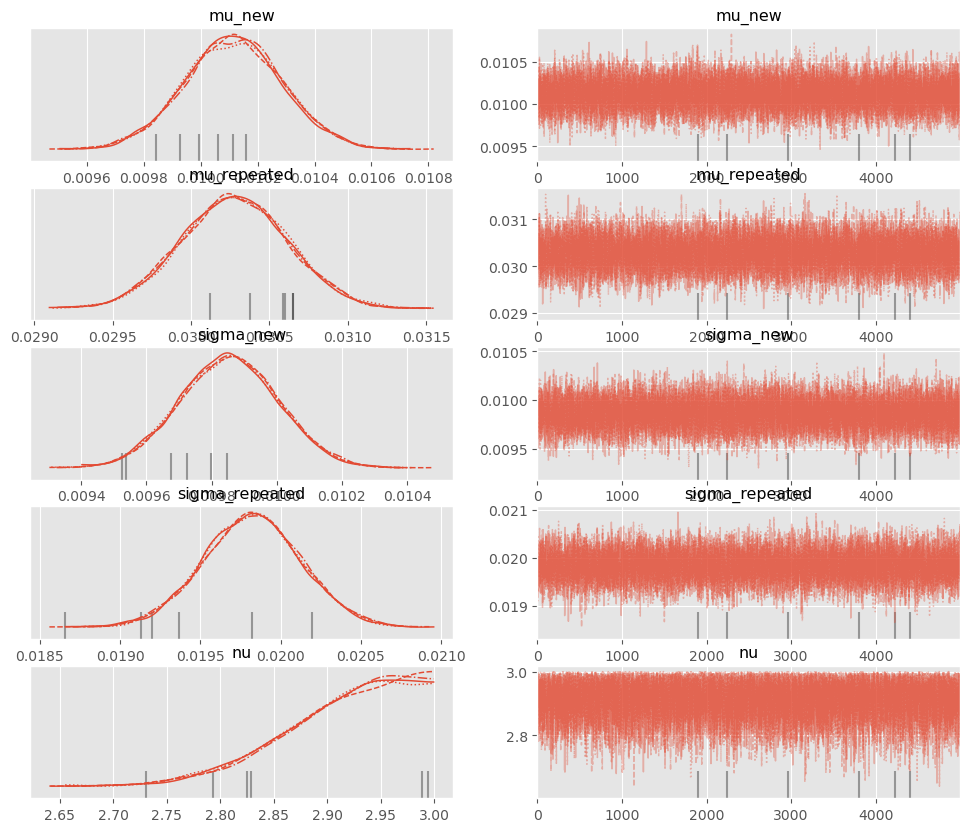

In [14]:
az.plot_trace(trace);

In [15]:
with pm.Model() as default_rate_model:
    mu_new = pm.HalfNormal('mu_new', sigma=0.01)
    mu_repeated = pm.HalfNormal('mu_repeated', sigma=0.02)  
    
    sigma_new = pm.InverseGamma('sigma_new', alpha=2, beta=0.01)
    sigma_repeated = pm.InverseGamma('sigma_repeated', alpha=2, beta=0.02)

    # Prior for the degrees of freedom, wider range 
    nu = pm.Uniform('nu', lower=2, upper=5)

    likelihood_new = pm.StudentT('likelihood_new', nu=nu, mu=mu_new, sigma=sigma_new, observed=default_rates_new)
    likelihood_repeated = pm.StudentT('likelihood_repeated', nu=nu, mu=mu_repeated, sigma=sigma_repeated, observed=default_rates_repeated)

    trace = pm.sample(5000, tune=2500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_new, mu_repeated, sigma_new, sigma_repeated, nu]


Sampling 4 chains for 2_500 tune and 5_000 draw iterations (10_000 + 20_000 draws total) took 12 seconds.


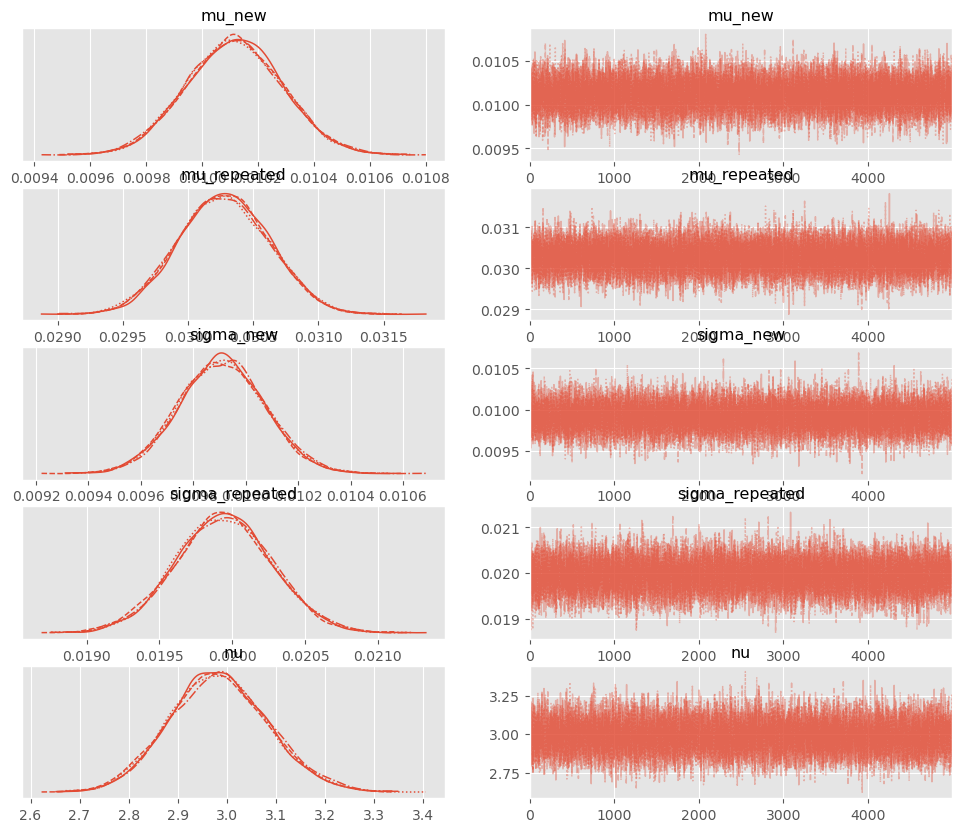

In [16]:
az.plot_trace(trace);

In [ ]:
# # plot causal relationships in model
# pm.model_to_graphviz(default_rate_model)

### Check posterior predictive

In [ ]:
# az.plot_trace(trace);

* stationarity (good! we need this for the `MCMC` simulation to converge...)
* note 4 chains (essentially all lying on top of each other, LHS-plot)

### Summarize posterior

In [ ]:
# az.summary(trace)

* see mean value for `default_rate` sampled from posterior distribution (3.7%)
* see value for `r_hat`: the closer it is to `1`, the more the model converges

In [ ]:
# Posterior analysis
# az.plot_posterior(trace, var_names=['default_rate']);

* mean value realistic

In [ ]:
# with default_rate_model:
#     posterior_predictive = pm.sample_posterior_predictive(trace)
#     data = az.from_pymc3(trace=trace, posterior_predictive=posterior_predictive)

In [ ]:
# # Plotting posterior distribution vs real distribution using ArviZ
# az.plot_ppc(data, var_names=['defaults'], alpha=0.5)
# plt.xlabel('Defaults')
# plt.ylabel('Density')
# plt.title('Posterior Predictive Check')

* actually, posterior distribution fits a lot more what one would expect re data-generating process (i.e. surely not a uniform distribution)
    - realistic mean val
    - long tail to the right